Homework 2 - Eugene Mesgar
---------------------------------

Consider population.csv file that is in the categorical_cols folder and answer the following:
1. Separate categorical columns from numerical columns. Apply OneHot encoding to categorical features.
2. Identify the numerical features that are normally distributed using Shapiro Wilk's test and apply standard scaler on the features that are normally distributed and min-max on the non-normal numerical features.
3. Then use preprocessor and makepipeline (or pipeline) to automatically apply the transformations and logistic regression and make prediction. Print confusion matrix, accuracy score and AUC.
Use the Markdown feature in the notebook to explain the steps.
 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.compose import make_column_selector as col_selector

from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)



In [2]:
df = pd.read_csv("population.csv")

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               32561 non-null  int64 
 1   Job Type          32561 non-null  object
 2   Final Weight      32561 non-null  int64 
 3   Education         32561 non-null  object
 4   Education Number  32561 non-null  int64 
 5   Marital Status    32561 non-null  object
 6   Job Title         32561 non-null  object
 7   Relationship      32561 non-null  object
 8   Race              32561 non-null  object
 9   Gender            32561 non-null  object
 10  Capital Gain      32561 non-null  int64 
 11  Capital Loss      32561 non-null  int64 
 12  Hours per week    32561 non-null  int64 
 13  Country           32561 non-null  object
 14  Income            32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df.head(10)

,Age,Job Type,Final Weight,Education,Education Number,Marital Status,Job Title,Relationship,Race,Gender,Capital Gain,Capital Loss,Hours per week,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
#
# Encode "Income" as the target variable and drop it from the dataframe
# 

label_encoder = LabelEncoder()

Y = label_encoder.fit_transform(df['Income'])
df.drop(['Income'], axis=1, inplace=True)


#Education Number has been dropped as it is a duplicate of Education
df.drop(['Education Number'], axis=1, inplace=True)


In [6]:
#
#  Seperate features into categorical, normally distributed and non-normally distributed.
#


categorical_features = []
numeric_normal_features = []
numeric_non_normal_features = []

for col in df.columns:

       vcount = len(df[col].value_counts() )
       dtype = df[col].dtype

       if dtype == 'object':
              categorical_features.append(col)
       else:
              stat, p = stats.shapiro(df[col].sample(4999))

              
              if(p > 0.05):
                     numeric_normal_features.append(col)
              else:
                     numeric_non_normal_features.append(col)



print("Categorical Features: ", categorical_features)
print("Numeric Non-Normal Features: ", numeric_non_normal_features)
print("Numeric Normal Features: ", numeric_normal_features)



Categorical Features:  ['Job Type', 'Education', 'Marital Status', 'Job Title', 'Relationship', 'Race', 'Gender', 'Country']
Numeric Non-Normal Features:  ['Age', 'Final Weight', 'Capital Gain', 'Capital Loss', 'Hours per week']
Numeric Normal Features:  []


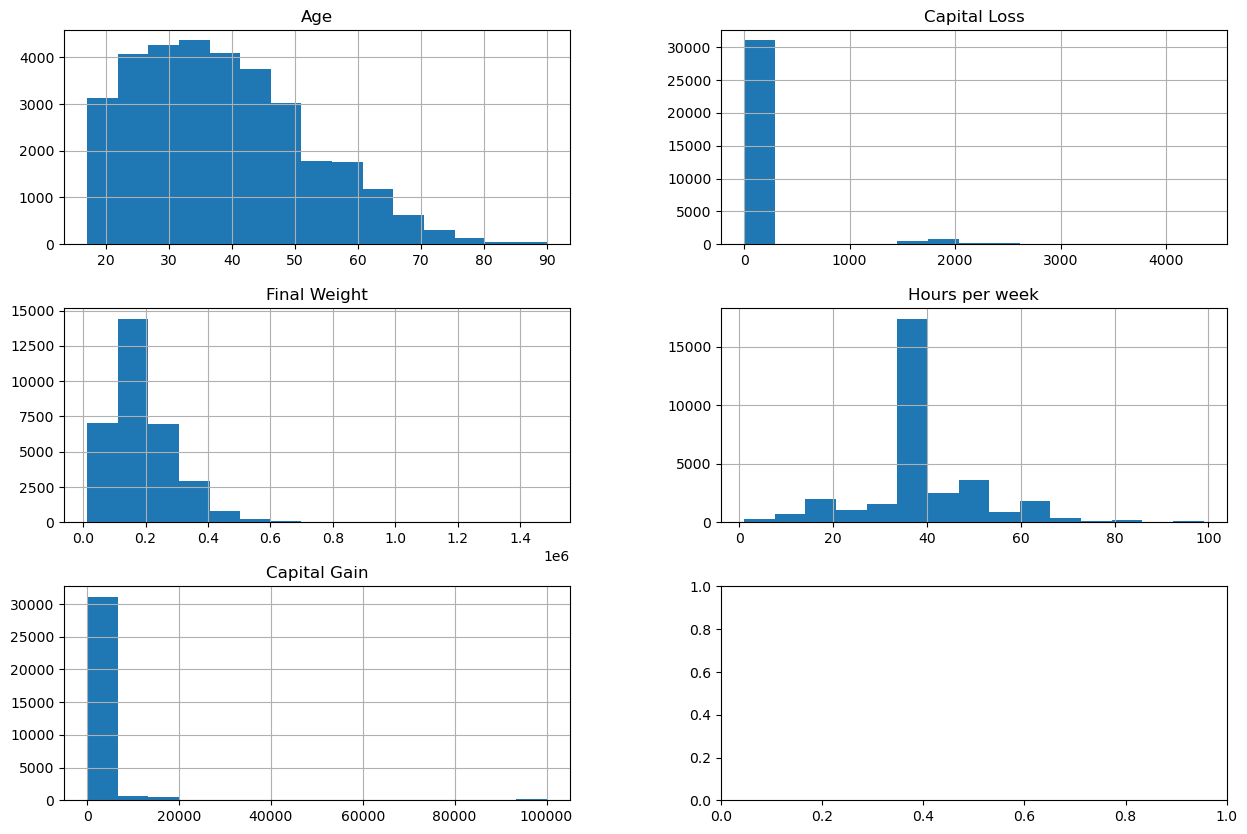

In [7]:
#
# Plot numeric features to confirm visually there are no normal distributions in the data.  We ruled out normality in the last cell
# but Shapiro wilks is not effective at n>5000.  I sampled the set below to 5000 and ran the test again and confirmed no noramlity but
# plotting again for confirmation
#

import matplotlib.pyplot as plt

variables= numeric_non_normal_features + numeric_normal_features

n_cols=2
n_rows= (len(variables)+(n_cols-1)) // n_cols 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,10))

for i, var_name in enumerate(variables):

    row = i % n_rows
    col = i // n_rows
    df[var_name].to_frame().hist(bins=15,ax=axes[row,col])



In [8]:
#
# Encode/scale the data
#

# Instantiate the encoders
one_hot_encoder = OneHotEncoder(sparse_output=False)
minmax_encoder = MinMaxScaler()
standard_scalar = StandardScaler()


# Process the non-categorical features
df_minmax = pd.DataFrame(minmax_encoder.fit_transform(df[numeric_non_normal_features]), columns=numeric_non_normal_features)
df_standard = pd.DataFrame() if len(numeric_normal_features) == 0 else pd.DataFrame(standard_scalar.fit_transform(df[numeric_normal_features]), columns=numeric_normal_features)


# Process the categorical features
one_hot_subdf = []
one_hot_dense = one_hot_encoder.fit_transform(df[categorical_features])

#Encode each categorical feature
i=0
for j, cat in enumerate(one_hot_encoder.categories_):    
    col_names = categorical_features[j] + cat
    sub_df = pd.DataFrame(one_hot_dense[:,i:i+len(cat) - 1], columns=col_names[:-1])
    one_hot_subdf.append(sub_df.copy())
    i += len(cat) 

#Concatenate the one-hot encoded features   
df_onehot = pd.concat(one_hot_subdf, axis=1)

#Concatenate all the features
df_x = pd.concat([df_minmax, df_standard, df_onehot], axis=1)

df_x.head(10)


,Age,Final Weight,Capital Gain,Capital Loss,Hours per week,Job Type ?,Job Type Federal-gov,Job Type Local-gov,Job Type Never-worked,Job Type Private,Job Type Self-emp-inc,Job Type Self-emp-not-inc,Job Type State-gov,Education 10th,Education 11th,Education 12th,Education 1st-4th,Education 5th-6th,Education 7th-8th,Education 9th,Education Assoc-acdm,Education Assoc-voc,Education Bachelors,Education Doctorate,Education HS-grad,Education Masters,Education Preschool,Education Prof-school,Marital Status Divorced,Marital Status Married-AF-spouse,Marital Status Married-civ-spouse,Marital Status Married-spouse-absent,Marital Status Never-married,Marital Status Separated,Job Title ?,Job Title Adm-clerical,Job Title Armed-Forces,Job Title Craft-repair,Job Title Exec-managerial,Job Title Farming-fishing,Job Title Handlers-cleaners,Job Title Machine-op-inspct,Job Title Other-service,Job Title Priv-house-serv,Job Title Prof-specialty,Job Title Protective-serv,Job Title Sales,Job Title Tech-support,Relationship Husband,Relationship Not-in-family,Relationship Other-relative,Relationship Own-child,Relationship Unmarried,Race Amer-Indian-Eskimo,Race Asian-Pac-Islander,Race Black,Race Other,Gender Female,Country ?,Country Cambodia,Country Canada,Country China,Country Columbia,Country Cuba,Country Dominican-Republic,Country Ecuador,Country El-Salvador,Country England,Country France,Country Germany,Country Greece,Country Guatemala,Country Haiti,Country Holand-Netherlands,Country Honduras,Country Hong,Country Hungary,Country India,Country Iran,Country Ireland,Country Italy,Country Jamaica,Country Japan,Country Laos,Country Mexico,Country Nicaragua,Country Outlying-US(Guam-USVI-etc),Country Peru,Country Philippines,Country Poland,Country Portugal,Country Puerto-Rico,Country Scotland,Country South,Country Taiwan,Country Thailand,Country Trinadad&Tobago,Country United-States,Country Vietnam
0,0.301370,0.044302,0.021740,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.452055,0.048238,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.287671,0.138113,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.493151,0.151068,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.150685,0.221488,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.273973,

model score (accuracy): 0.846
AUC: 0.902


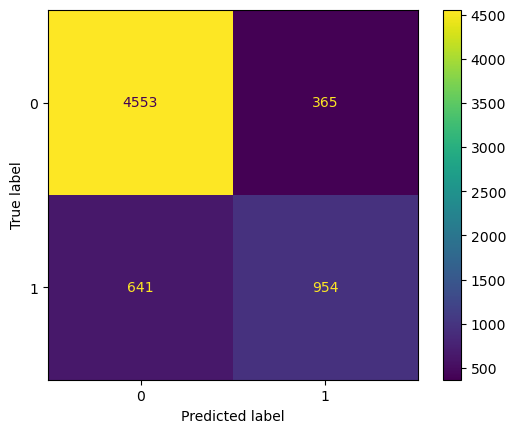

In [9]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(df_x, Y, test_size=0.2, random_state=0)

# Fit a logistic regression model to the training data
model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)

# Evaluate the model on the test data
y_pred = model.predict(x_test)
print("model score (accuracy): %.3f" % model.score(x_test, y_test))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Calculate the AUC
auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
print("AUC: %.3f" % auc)

Model accuracy: 0.846
AUC: 0.902


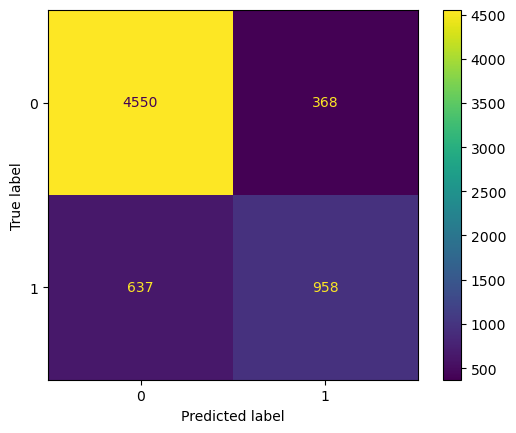

In [10]:
# Alternate method using make_pipeline

X = df


preprocessor = ColumnTransformer(
               transformers=[
               ('num', MinMaxScaler(), numeric_non_normal_features),
               ('cat', OneHotEncoder(), categorical_features)])


clf = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("Model accuracy: %.3f" % clf.score(X_test, y_test))

# Calculate the AUC
auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
print("AUC: %.3f" % auc)


y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)


disp.plot()


# Conclusion


We proprocessed the population dataset two ways.  In the first method, we seperated the features manually into categorical and numeric features, applied the appropriate scalars and then concatened the data back together to create our test & training set.  In the second approach, we used make_pipeline which handles the intermediate steps.     Both processes yield the same model accuracy, etc. **Make pipeline saves a lot of time!**
